## Initialization
- Import the package
- Import the data
    - prescreen
    - discrimination
    - main task 
    - catch trials

In [1]:
import csv
import numpy as np
import pandas as pd
from collections import defaultdict
import string
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
from sklearn import metrics # confusion matrix, MSE etc.

In [2]:
## Read the data
path_to_data = "/Users/t.z.cheng/Google_Drive/Research/cross_domain_entrainment/exp8/results/session-63769574ee2f0792ad9a3641-data.csv"
df = pd.read_csv(path_to_data)
# df.groupby('stimuli_presented').describe()[30:63]
# df_clean = df
## Take a look of the dataset
# df.head()
# df.tail()
# df.loc[558:663] # see specific rows of data

In [3]:
## Clean up task and subject ID (first five characters)
df['task'] = df['trial_template'].apply(lambda x: x.split("_")[0])
df['sub_id'] = df['participant_id'].apply(lambda x: x.split()[0][0:5])

In [4]:
## Add the accuracy and PPS column to the dataset: transform True and Shorter to 1, False and longer to 0
Correct = [] # only applied for the prescreen
Shorter = []
for i in np.arange(0,len(df)):
    if df['response_value'][i] == df['stimuli_presented'][i]:
        Correct.append(1)
    else: 
        Correct.append(0)
    if df['response_value'][i] == "Lap":
        Shorter.append(1)
    else: 
        Shorter.append(0)
df['Correct'] = Correct
df['Shorter'] = Shorter

In [5]:
## Total participated subjects
len(df['sub_id'].unique())

96

In [6]:
## for exp8abc
df['exp'] = df['group_id'].apply(lambda x: x.split("_")[0])
df_exp8a = df[(df['exp'] == 'EXP8a')].reset_index(drop = True)
df = df_exp8a

## Set parameters
- Accuracy threshold for the easiest trials of the main task 
- Extreme RT threshold
- Catch trial accuracy

In [7]:
## Parameters
threshold = .55
catch_threshold = .9
RT_threshold = 10000
pretest_threshold = 0.6

## Data cleaning 
***Super important: df_clean is overwritten after each step of data cleaning***

**Reject subjects**
- Catch trial
- Environmental noise & audio device (may not need to use them as criteria)

**Reject trials**
- Task-relevant trials
- Extreme RT

### Reject subjects 

In [8]:
## How many subjects miss the catch trial 
catch_trials = ['Catch_cat','Catch_bird']
catch_trials = ['Catch_trials'] ## for exp8abc

df_catch = df[(df['trial_template'].isin(catch_trials))].reset_index(drop = True) # reset index from 1
catch_acc = df_catch.groupby('sub_id')['response_correct'].sum()/df_catch.groupby('sub_id')['response_correct'].count()
fail_catch = catch_acc[catch_acc < catch_threshold].reset_index()
fail_catch

,sub_id,response_correct
0,259a7,0.461538


In [9]:
## remove subjects who failed the catch trial based on the threshold
df_clean = df[~df['sub_id'].isin(fail_catch['sub_id'])].reset_index(drop = True)

In [10]:
## How many subjects had a bad environmental noise and device
df_noise = df[(df['response_name'] == 'survey_noise')].reset_index(drop = True)
noise = df_noise.groupby('sub_id')['response_value'].sum()
too_noisy = noise[noise == '4'].reset_index()
too_noisy

,sub_id,response_value
0,9e9e5,4


In [11]:
## remove subjects who completed the task in noisy environment
df_clean = df_clean[~df_clean['sub_id'].isin(too_noisy['sub_id'])].reset_index(drop = True)

In [12]:
df_device = df[(df['response_name'] == 'survey_headphone1')].reset_index()
len(df_device[['sub_id','response_value']] == 'Yes')

32

In [13]:
df_device = df[(df['response_name'] == 'survey_headphone2')].reset_index(drop = True)
df_device[['sub_id','response_value']]

,sub_id,response_value
0,d6367,Wireless Headphones
1,ffb12,Wireless Earbuds
2,72c4b,Wireless Headphones
3,6bc9f,Wireless Earbuds
4,297cf,Wireless Earbuds
5,9e9e5,Wired Headphones
6,41bb7,Built in Laptop/Desktop Speaker (Please use he...
7,e5ba0,Wireless Earbuds
8,a2ca6,Wireless Earbuds
9,573e8,Wireless Headphones


### Task relevant trials

In [14]:
## prescreen condition
conds = ['Lack','Lag','Cap','Cab','Beat','Bead',
        'Fat','Fad','Back','Bag','Lap','Lab']
## select the prescreen trials 
df_pre = df_clean[(df_clean['stimuli_presented'].isin(conds)) & (df_clean['task'] == "PrescreenTrials")].reset_index()
df_pre.groupby(['sub_id','stimuli_presented'])['Correct'].mean()
pre_acc = df_pre.groupby(['sub_id'])['Correct'].mean()
fail_pre = pre_acc[pre_acc < pretest_threshold].reset_index()

In [15]:
df_clean = df_clean[~df_clean['sub_id'].isin(fail_pre['sub_id'])].reset_index(drop = True)

In [16]:
## After cleaning how many subjects left
len(df_clean['sub_id'].unique())

29

In [17]:
## Discrimination task 
conds = ['Lab1','Lab2','Lab3','Lab4','Lab5','Lab6','Lab7','Lab8']
## select the discrimination trials 
df_disc = df_clean[(df_clean['stimuli_presented'].isin(conds)) & (df_clean['task'] == "DiscriminationTrials")].reset_index(drop = True)
df_disc.groupby('stimuli_presented')['Shorter'].mean()

stimuli_presented
Lab1    0.614943
Lab2    0.536782
Lab3    0.442529
Lab4    0.343678
Lab5    0.217241
Lab6    0.190805
Lab7    0.170115
Lab8    0.155172
Name: Shorter, dtype: float64

In [18]:
## Main task conditions
conds = ['early_Lab1','early_Lab2','early_Lab3','early_Lab4','early_Lab5','early_Lab6','early_Lab7','early_Lab8',
         'ontime_Lab1','ontime_Lab2','ontime_Lab3','ontime_Lab4','ontime_Lab5','ontime_Lab6','ontime_Lab7','ontime_Lab8',
         'late_Lab1','late_Lab2','late_Lab3','late_Lab4','late_Lab5','late_Lab6','late_Lab7','late_Lab8']
## select the main trials 

## for exp8abc
# df_clean = df_clean[(df_clean['stimuli_presented'].isin(conds)) & (df_clean['task'] == "maintaskTrials")].reset_index(drop = True)
df_clean = df_clean[(df_clean['stimuli_presented'].isin(conds)) & (df_clean['task'] == "EXP8a")].reset_index(drop = True)
print(len(df_clean['sub_id'].unique()))
df_clean.groupby('stimuli_presented')['Shorter'].mean()

29


stimuli_presented
early_Lab1     0.798851
early_Lab2     0.701149
early_Lab3     0.551724
early_Lab4     0.336207
early_Lab5     0.126437
early_Lab6     0.112069
early_Lab7     0.103448
early_Lab8     0.077586
late_Lab1      0.790230
late_Lab2      0.678161
late_Lab3      0.571839
late_Lab4      0.272989
late_Lab5      0.137931
late_Lab6      0.129310
late_Lab7      0.089080
late_Lab8      0.080460
ontime_Lab1    0.785714
ontime_Lab2    0.666667
ontime_Lab3    0.557471
ontime_Lab4    0.272989
ontime_Lab5    0.109195
ontime_Lab6    0.091954
ontime_Lab7    0.112069
ontime_Lab8    0.083744
Name: Shorter, dtype: float64

In [19]:
## Long format for each condition
# B/T: presenting order & response key
# W/I: Onset time, comparison length, delay length
df_clean['Onset'] = df_clean['stimuli_presented'].apply(lambda x: x.split("_")[-2])
df_clean['comparison'] = df_clean['stimuli_presented'].apply(lambda x: x.split("_")[-1][3])
df_clean['key'] = df_clean['group_id'].apply(lambda x: x.split("_")[-1])

In [20]:
## Sanity check for trial number
df_clean.groupby('stimuli_presented').describe()

network_error_repeat                                     \
                                 count mean  std  min  25%  50%  75%  max   
stimuli_presented                                                           
early_Lab1                       348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
early_Lab2                       348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
early_Lab3                       348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
early_Lab4                       348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
early_Lab5                       348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
early_Lab6                       348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
early_Lab7                       348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
early_Lab8                       348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
late_Lab1                        348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
late_Lab2                        348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
late_Lab3                        348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
late_Lab4                        348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
late_Lab5                        348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
late_Lab6                        348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
late_Lab7                        348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
late_Lab8                        348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ontime_Lab1                      406.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ontime_Lab2                      348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ontime_Lab3                      348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ontime_Lab4                      348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ontime_Lab5                      348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ontime_Lab6                      348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ontime_Lab7                      348.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ontime_Lab8                      406.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                  participation_duration               ... Correct       \
                                   count         mean  ...     75%  max   
stimuli_presented                                      ...                
early_Lab1                         348.0  3086.831212  ...     0.0  0.0   
early_Lab2                         348.0  3086.831212  ...     0.0  0.0   
early_Lab3                         348.0  3086.831212  ...     0.0  0.0   
early_Lab4                         348.0  3086.831212  ...     0.0  0.0   
early_Lab5                         348.0  3086.831212  ...     0.0  0.0   
early_Lab6                         348.0  3086.831212  ...     0.0  0.0   
early_Lab7                         348.0  3086.831212  ...     0.0  0.0   
early_Lab8                         348.0  3086.831212  ...     0.0  0.0   
late_Lab1                          348.0  3086.831212  ...     0.0  0.0   
late_Lab2                          348.0  3086.831212  ...     0.0  0.0   
late_Lab3                          348.0  3086.831212  ...     0.0  0.0   
late_Lab4                          348.0  3086.831212  ...     0.0  0.0   
late_Lab5                          348.0  3086.831212  ...     0.0  0.0   
late_Lab6                          348.0  3086.831212  ...     0.0  0.0   
late_Lab7                          348.0  3086.831212  ...     0.0  0.0   
late_Lab8                          348.0  3086.831212  ...     0.0  0.0   
ontime_Lab1                        406.0  3086.831212  ...     0.0  0.0   
ontime_Lab2                        348.0  3086.831212  ...     0.0  0.0   
ontime_Lab3                        348.0  3086.831212  ...     0.0  0.0   
ontime_Lab4                        348.0  3086.831212  ...     0.0  0.0   
ontime_Lab5                        348.0  3086.831212  ...     0.0  0.0   
ontime_Lab6                        348.0  3086.831212  ...     0.0  0.0   
ontime_Lab7                        348.0  3086.831212  ...     

### Extreme reaction time

In [21]:
df_clean_longRT = df_clean[df_clean['response_rt'] > RT_threshold]

In [22]:
len(df_clean_longRT['sub_id'].unique())

10

In [23]:
RT_threshold
df_clean_longRT.head()

,branch_failpass,expt_id,group_id,network_error_repeat,participant_id,participation_duration,response_correct,response_mode,response_name,response_rt,...,trial_num,trial_template,task,sub_id,Correct,Shorter,exp,Onset,comparison,key
601,NaN,6345b7f49677d36bd07c5a10,EXP8a_FJ,0,72c4bf638828597ccf002a84e6b24fa3dad4d7fc108209...,7760.309079,False,keypress,testRsp,20305,...,382,EXP8a_maintaskTrials,EXP8a,72c4b,0,0,EXP8a,late,2,FJ
650,NaN,6345b7f49677d36bd07c5a10,EXP8a_FJ,0,72c4bf638828597ccf002a84e6b24fa3dad4d7fc108209...,7760.309079,False,keypress,testRsp,133825,...,435,EXP8a_maintaskTrials,EXP8a,72c4b,0,0,EXP8a,early,4,FJ
679,NaN,6345b7f49677d36bd07c5a10,EXP8a_FJ,0,72c4bf638828597ccf002a84e6b24fa3dad4d7fc108209...,7760.309079,False,keypress,testRsp,50753,...,467,EXP8a_maintaskTrials,EXP8a,72c4b,0,0,EXP8a,ontime,7,FJ
699,NaN,6345b7f49677d36bd07c5a10,EXP8a_FJ,0,72c4bf638828597ccf002a84e6b24fa3dad4d7fc108209...,7760.309079,False,keypress,testRsp,12995,...,489,EXP8a_maintaskTrials,EXP8a,72c4b,0,0,EXP8a,ontime,8,FJ
706,NaN,6345b7f49677d36bd07c5a10,EXP8a_FJ,0,72c4bf638828597ccf002a84e6b24fa3dad4d7fc108209...,7760.309079,False,keypress,testRsp,10673,...,496,EXP8a_maintaskTrials,EXP8a,72c4b,0,0,EXP8a,early,6,FJ


In [24]:
df_clean = df_clean[df_clean['response_rt'] < RT_threshold]

## Group by to do condition comparision

In [25]:
## Number of subjects, trials & conditions for each subjects
n_subj = len(df_clean['sub_id'].unique())
n_trial = len(df_clean)//(24*n_subj)
n_conds = len(df_clean['stimuli_presented'].unique())
print('Participant_number:', n_subj,'Trial number:', n_trial,'Condition number:', n_conds, sep='\n')

Participant_number:
29
Trial number:
12
Condition number:
24


In [26]:
## Group_by across subjects
df_clean.groupby(['Onset'])['Shorter'].mean().reset_index()

,Onset,Shorter
0,early,0.351156
1,late,0.345014
2,ontime,0.339910


In [27]:
pps = df_clean.groupby(['Onset'])['Shorter'].mean()
print('Proportion short')
print('Early',pps[0]) 
print('Ontime',pps[2])
print('Late',pps[1])

Proportion short
Early 0.3511560693641618
Ontime 0.3399100034614053
Late 0.345014450867052


In [28]:
## Group_by for each subject: mean
pps_all = df_clean.groupby(['stimuli_presented'])['Shorter'].mean()
print(pps_all)
## Outliers: define as the ones who are three stds away from the mean
#outliers = overall_pps - overall_pps.mean() > 3*overall_pps.std()
#sum(outliers)

stimuli_presented
early_Lab1     0.801153
early_Lab2     0.703170
early_Lab3     0.553936
early_Lab4     0.337209
early_Lab5     0.126437
early_Lab6     0.109827
early_Lab7     0.103746
early_Lab8     0.075145
late_Lab1      0.792507
late_Lab2      0.681159
late_Lab3      0.575145
late_Lab4      0.270893
late_Lab5      0.138329
late_Lab6      0.130435
late_Lab7      0.089595
late_Lab8      0.081159
ontime_Lab1    0.791563
ontime_Lab2    0.668588
ontime_Lab3    0.557471
ontime_Lab4    0.272989
ontime_Lab5    0.109510
ontime_Lab6    0.089595
ontime_Lab7    0.112717
ontime_Lab8    0.084158
Name: Shorter, dtype: float64


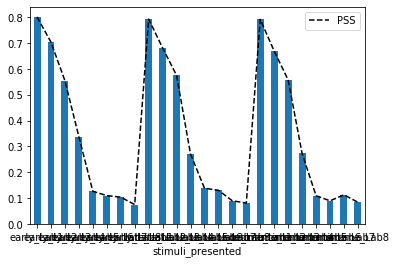

In [29]:
## Visualization: bar plot
PPS_plot = pd.DataFrame({'Conditions': conds, 'PSS': pps_all})
ax = PPS_plot.plot.bar(rot = 0)
pps_all.plot(style='k--')

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8')]

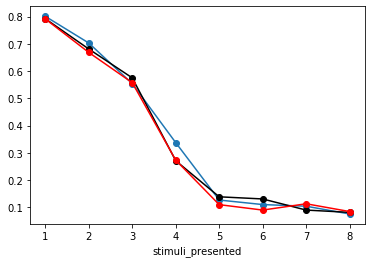

In [30]:
pps_all[0:8].plot(style = 'o-') # early
pps_all[8:16].plot(style ='ko-') # late
ax = pps_all[16:24].plot(style ='ro-') # ontime
ax.set_xticklabels([0,1,2,3,4,5,6,7,8])

### Statistic tests

In [31]:
PPS = df_clean.groupby(['sub_id','Onset'])['Shorter'].mean()
PPS_early = PPS[::3]
PPS_ontime = PPS[2::3]
PPS_late = PPS[1::3]

In [32]:
PPS_early.mean()

0.35088210181526747

In [33]:
PPS_ontime.mean()

0.33961722419679774

In [34]:
PPS_late.mean()

0.34471653825102105

In [35]:
print(stats.ttest_rel(PPS_early, PPS_late))
print(stats.ttest_rel(PPS_early, PPS_ontime))
print(stats.ttest_rel(PPS_late, PPS_ontime))

Ttest_relResult(statistic=0.7386311957742854, pvalue=0.466277735872934)
Ttest_relResult(statistic=1.1916326229754195, pvalue=0.24340818277201626)
Ttest_relResult(statistic=0.7678328179011291, pvalue=0.4490138146890267)


## Save the onset and comparison length to the csv file for R analysis

In [ ]:
## save df to csv
df_clean.to_csv(r'/Users/t.z.cheng/Google_Drive/Research/cross_domain_entrainment/exp6_21CR03_Vowel_length/FF2021/results/EXP6_clean_n64.csv', header=True)